## 패션 MNIST

참고:
* https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/keras/classification.ipynb
* https://archive.is/fY0FO

In [1]:
#텐서플로 모델을 만들고 훈련할 수 있는 고수준 API인 tf.keras를 사용
# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.0


* 10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용
* 트레이닝 : 60,000개 이미지, 평가 : 10,000개 이미지(네트워크가 얼마나 정확하게 이미지를 분류하는지)
* 이미지는 28x28 픽셀이고, 다음처럼 개별 옷 품목을 나타냄

<img src='../images/fasion_mnist_dataset.png' width=400px />

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환:
* train_images, train_labels 배열 : 모델 학습에 사용되는 훈련 셋
* test_images, test_labels 배열은 모델 테스트에 사용되는 테스트 셋

* 이미지 : 28x28 크기의 넘파이 배열 <br>
* 픽셀 값 : 0~255 사이의 값 <br>
* 레이블(label) : 0에서 9까지의 정수 배열 >>> 이미지에 있는 옷의 클래스(class)를 나타냄

<img src='../images/fasion_mnist_label.png' width=150px />

* 각 이미지는 하나의 레이블에 매핑되어 있음 <br>
데이터셋에 클래스 이름이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장:

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### 데이터 탐색

트레이닝셋에는 60,000개의 이미지, 28x28픽셀로 표현:

In [4]:
train_images.shape

(60000, 28, 28)

60,000개의 레이블을 가짐:

In [5]:
len(train_labels)

60000

각 label은 0~9 사이의 정수:

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

테스트셋에는 10,000개의 이미지, 28x28픽셀로 표현:

In [7]:
test_images.shape

(10000, 28, 28)

10,000개의 레이블을 가짐:

In [8]:
len(test_labels)

10000

In [9]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

### 데이터 전처리

픽셀 값의 범위는 0~255사이:

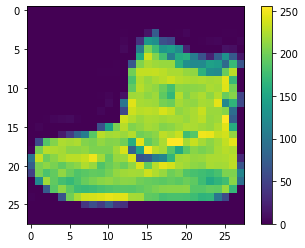

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

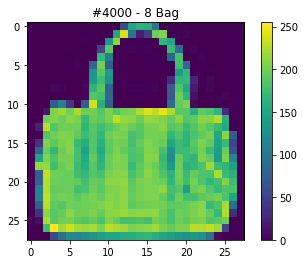

In [11]:
plt.figure()
idx_to_draw = 4000 # 바꾸어보세요
plt.imshow(train_images[idx_to_draw])

lbl = train_labels[idx_to_draw]

plt.title('#{} - {} {}'.format(idx_to_draw, lbl, class_names[lbl]))
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 넣기 전 값의 범위를 0 ~ 255에서 0 ~ 1사이로 조정하기 위해 트레이닝셋과 테스트셋을 각각 255로 나눔:

In [12]:
train_images = train_images / 255.0

test_images = test_images / 255.0

트레이닝셋에서 처음 25개 이미지와 클래스 이름 출력:

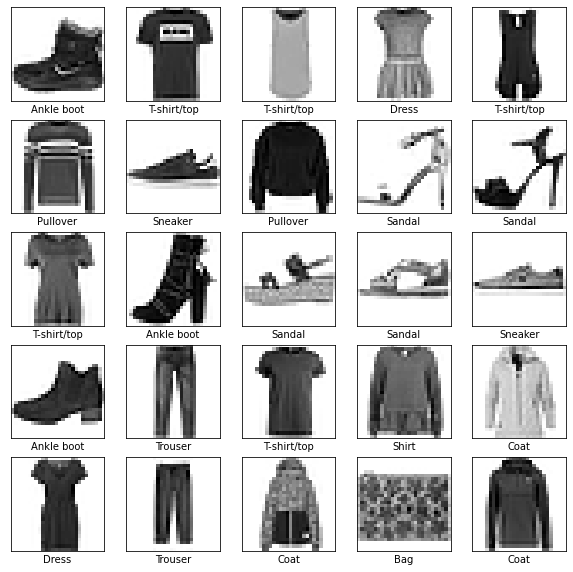

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### 모델 구성

신경망 모델 만들기 : 모델 층 구성 -> 모델 컴파일

#### 층 설정

* 신경망의 기본 구성 요소 : 층(layer)
* 층(layer)은 넣어진 데이터에서 추출
* tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됨

In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), # 2차원 배열(28x28 픽셀)의 이미지 포맷을 28*28=784 픽셀의 1차원 배열로 변환
                                                # 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘림
                                                # 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 함
    
    # 픽셀을 펼친 후, 두 개의 tf.keras.layers.Dense 층이 연속되어 연결
    # >> 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부름
    keras.layers.Dense(128, activation='relu'), # 28개의 노드(뉴런)를 가짐
    keras.layers.Dense(10, activation='softmax') # 10개의 노드(뉴런)의 소프트맥스(softmax) 층
                                                # 10개의 확률을 반환하고 반환된 값의 전체 합은 1
                                                # 각 노드(뉴런)는 현재 이미지가 10개의 클래스 중 하나에 속할 확률을 출력
])

### 모델 컴파일

모델 훈련 전 필요한 몇 가지 추가 단계:
* 손실 함수(Loss function) : 훈련 하는 동안 모델의 오차를 측정, 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 함
* 옵티마이저(Optimizer) : 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정
* 지표(Metrics) : 훈련 단계와 테스트 단계를 모니터링하기 위해 사용, 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 모델 훈련

신경망 모델 트레이닝 단계:
1. 트레이닝 데이터를 모델에 주입(train_images와 train_labels 배열)
2. 모델이 이미지와 레이블을 매핑하는 방법을 배움
3. 테스트셋에 대한 모델의 예측을 만듦(test_images 배열, 이 예측이 test_labels 배열의 레이블과 맞는지 확인)

트레이닝 시작을 위해 model.fit 메서드를 호출하면 모델이 훈련 데이터를 학습함:

In [16]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 431us/step - loss: 0.6365 - accuracy: 0.7761
Epoch 2/5
1875/1875 [==============================] - 1s 431us/step - loss: 0.3870 - accuracy: 0.8619
Epoch 3/5
1875/1875 [==============================] - 1s 430us/step - loss: 0.3364 - accuracy: 0.8789
Epoch 4/5
1875/1875 [==============================] - 1s 432us/step - loss: 0.3112 - accuracy: 0.8852
Epoch 5/5
1875/1875 [==============================] - 1s 433us/step - loss: 0.2972 - accuracy: 0.8905


모델이 트레이닝 되면서 loss와 accuracy가 출력, <br>
이 모델은 트레이닝셋에서 약 0.88(88%)정도의 정확도(accuracy)를 달성

### 정확도 평가

테스트셋에서 모델의 성능을 비교

In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\n테스트 정확도:', test_acc)

313/313 - 0s - loss: 0.3572 - accuracy: 0.8713

테스트 정확도: 0.8712999820709229


테스트셋의 정확도가 트레이닝셋의 정확도보다 조금 낮음 (테스트셋:0.86, 트레이닝셋:0.88) <br>
트레이닝셋의 정확도와 테스트셋의 정확도 사이의 차이는 과대적합(overfitting) 때문 <br>
* 과대적합(overfitting) : 머신러닝 모델이 트레이닝 데이터보다 새로운 데이터에서 성능이 낮아지는 현상

### 예측 만들기

훈련된 모델을 사용하여 이미지에 대한 예측을 만들 수 있음, 테스트셋에 있는 각 이미지의 레이블을 예측

In [18]:
predictions = model.predict(test_images)

첫 번째 예측 확인:

In [19]:
predictions[0]

array([1.0779821e-06, 3.4945810e-08, 6.0871150e-07, 7.8986153e-07,
       2.6309542e-06, 1.4051682e-02, 2.4553565e-06, 1.6659419e-01,
       1.9251963e-04, 8.1915390e-01], dtype=float32)

10개의 숫자 배열로 나타내며, 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냄 <br>
가장 높은 신뢰도를 가진 레이블 찾아보기:

In [20]:
np.argmax(predictions[0])

9

모델은 이 이미지가 class_name[9] = 앵클 부츠라고 가장 확신하고 있음 <br>
이 값이 맞는지 테스트 레이블을 확인:

In [21]:
test_labels[0]

9

10개 클래스에 대한 예측을 모두 그래프로 표현:

In [22]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
        plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인

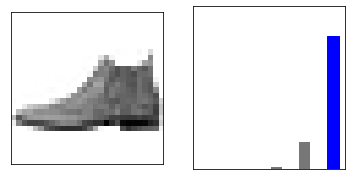

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

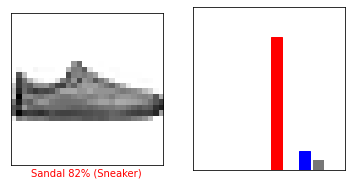

In [24]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해보자. <br>
* 올바르게 예측된 레이블 : 파란색
* 잘못 예측된 레이블 : 빨강색
* 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점), 신뢰도 점수가 높을 때도 잘못 예측할 수 있음

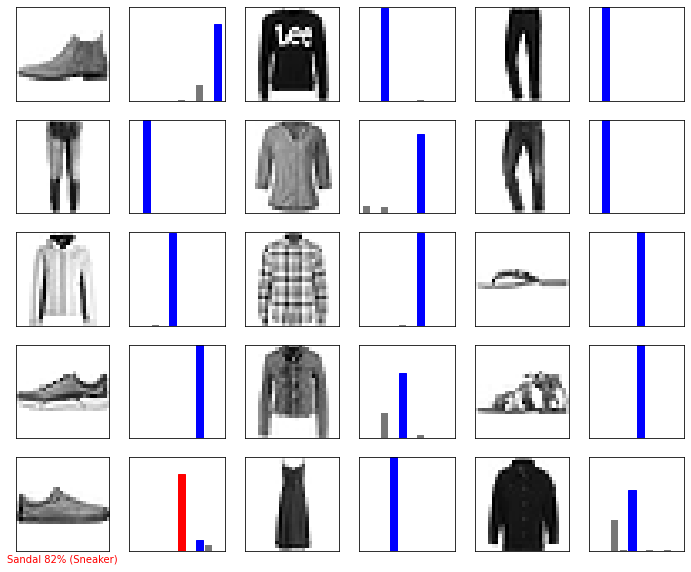

In [25]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

plt.show()

마지막으로 훈련된 모델을 사용하여 한 이미지에 대한 예측을 만듦

In [26]:
# 테스트 세트에서 이미지 하나를 선택합니다
img = test_images[0]

print(img.shape)

(28, 28)


tf.keras 모델은 한 번에 샘플의 묶음 또는 배치(batch)로 예측을 만드는데 최적화되어 있음 <br>
하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 함:

In [27]:
# 이미지 하나만 사용할 때도 배치에 추가합니다
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


이제 이 이미지의 예측을 만듦:

In [28]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.0779842e-06 3.4945810e-08 6.0871201e-07 7.8986005e-07 2.6309542e-06
  1.4051691e-02 2.4553565e-06 1.6659418e-01 1.9251961e-04 8.1915390e-01]]


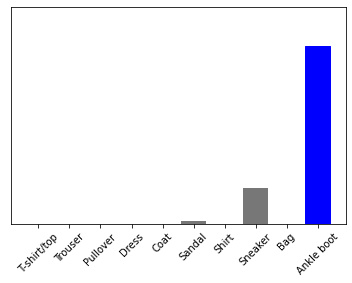

In [29]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

model.predict는 2차원 넘파이 배열을 반환하므로 첫 번째 이미지의 예측을 선택:

In [30]:
np.argmax(predictions_single[0])

9

이전과 마찬가지로 모델의 예측은 레이블 9